# The FR in the FourRooms environment

In [1]:
import matplotlib.collections as mcoll
import matplotlib.path as mpa
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax
import seaborn as sns
sns.set()
from importlib import reload 
import pickle
import pdb

# custom libraries 
import envs
from envs import *
import utils 
from utils import * 
import agents
from agents import *
from runners import * 
from frp import FRPAgent

# display options
np.set_printoptions(precision=4, suppress=1)
plt.style.use('https://github.com/nickteff/EconomistStyle/raw/master/theeconomist.mplstyle')

%load_ext autoreload
%autoreload 2

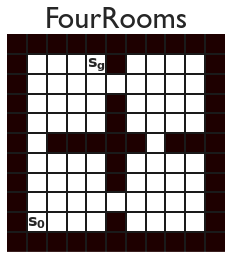

In [2]:
grid = FourRooms()
START_STATE = 100
grid.plot_grid(show_idxs=False)

To run FRP, we first need to define base policies. 

In [3]:
# base policies = simply go up, right, down, left
grid = FourRooms()
pi1 = SimpleAgent(grid._layout.size, grid.get_obs(), 0, rebound=False) # go up
pi2 = SimpleAgent(grid._layout.size, grid.get_obs(), 1, rebound=False) # go right
pi3 = SimpleAgent(grid._layout.size, grid.get_obs(), 2, rebound=False) # go down
pi4 = SimpleAgent(grid._layout.size, grid.get_obs(), 3, rebound=False) # go left

Now, we learn the associated FRs

In [4]:
# learn the FRs for the base policies
Pi = [pi1, pi2, pi3, pi4]
tds = []
FRs = []
# multiple start states 
grid = FourRooms()
start_states = grid._possible_reward_states # these are states without walls
for i, pi in enumerate(Pi): 
    print (f"\nlearning FR for policy {i+1}")
    fr_agent = FR(grid._layout.size, 4, grid.get_obs(),
              policy=greedy, q=pi.q,
              step_size=0.08, sa=False)
    tds_agent = []
    for i,start in enumerate(start_states):
        fr_agent._state = start
        grid = FourRooms(start_state=start, discount=0.95)
        results = run_experiment_episodic(
            grid, fr_agent, 100, display_eps=50, respect_done=True, max_ep_len=10
        )
        tds_agent.append(results['deltas'])
    tds.append(np.stack(tds_agent))
    FRs.append(fr_agent.FR)


learning FR for policy 1
ep 100/100: mean return = -3.13049815447080042
learning FR for policy 2
ep 100/100: mean return = -7.62399815447079782
learning FR for policy 3
ep 100/100: mean return = -7.62399815447079759
learning FR for policy 4
ep 100/100: mean return = -2.63174815447089953

In [6]:
# learn the SRs for the base policies
Pi = [pi1, pi2, pi3, pi4]
sr_tds = []
SRs = []
# multiple start states 
grid = FourRooms()
start_states = grid._possible_reward_states # these are states without walls
for i, pi in enumerate(Pi): 
    print (f"\nlearning SR for policy {i+1}")
    sr_agent = SR(grid._layout.size, 4, grid.get_obs(),
              policy=greedy, q=pi.q,
              step_size=0.08, sa=False)
    tds_agent = []
    for i,start in enumerate(start_states):
        sr_agent._state = start
        grid = FourRooms(start_state=start, discount=0.95)
        results = run_experiment_episodic(
            grid, sr_agent, 100, display_eps=50, respect_done=True, max_ep_len=10
        )
        tds_agent.append(results['deltas'])
    sr_tds.append(np.stack(tds_agent))
    SRs.append(sr_agent.SR)


learning SR for policy 1
ep 100/100: mean return = -3.13049815447080042
learning SR for policy 2
ep 100/100: mean return = -7.62399815447079782
learning SR for policy 3
ep 100/100: mean return = -7.62399815447079759
learning SR for policy 4
ep 100/100: mean return = -2.63174815447089953

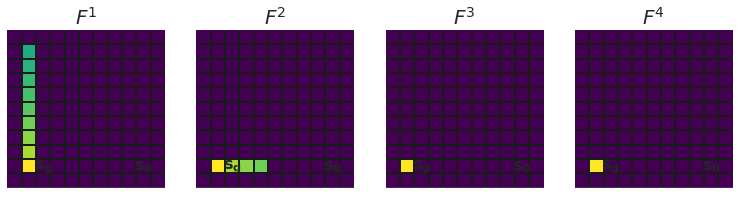

In [8]:
# let's visualize the FRs from the start state
fig, axs = plt.subplots(1, 4, figsize=(13, 4))
for i,fr in enumerate(FRs):
    grid.plot_grid(M=fr[START_STATE, ...], ax=axs[i])
    axs[i].set_title(r"$F^{}$".format(i+1), fontsize=20)
plt.show()

Now we'll run FRP, increasing the maximum number of sweeps allowed to see the effects on the resulting plan

In [9]:
# now we run the planning algorithm for K = 0, 1, 2, 3, 4
grid = FourRooms()
pl_agent0 = FRPAgent(
    grid._layout.size, 4, grid.get_obs(), grid._possible_reward_states, Pi, FRs, max_sweeps=0
) #
pl_agent1 = FRPAgent(
    grid._layout.size, 4, grid.get_obs(), grid._possible_reward_states, Pi, FRs, max_sweeps=1
) #
pl_agent2 = FRPAgent(
    grid._layout.size, 4, grid.get_obs(), grid._possible_reward_states, Pi, FRs, max_sweeps=2
) #
pl_agent3 = FRPAgent(
    grid._layout.size, 4, grid.get_obs(), grid._possible_reward_states, Pi, FRs, max_sweeps=3
) #
pl_agent4 = FRPAgent(
    grid._layout.size, 4, grid.get_obs(), grid._possible_reward_states, Pi, FRs, max_sweeps=4
) #

In [10]:
pl_agents = [pl_agent0, pl_agent1, pl_agent2, pl_agent3, pl_agent4] # list of agents

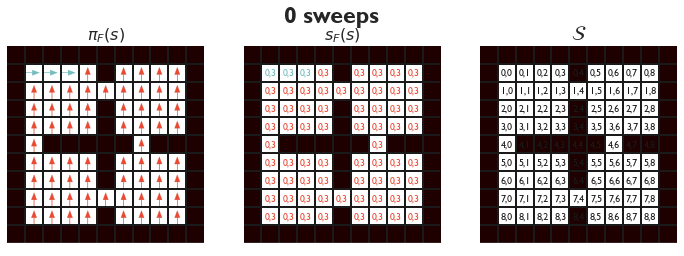

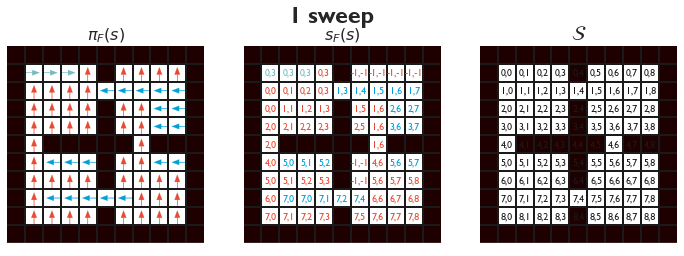

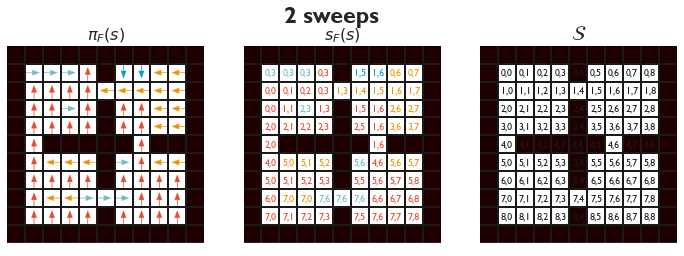

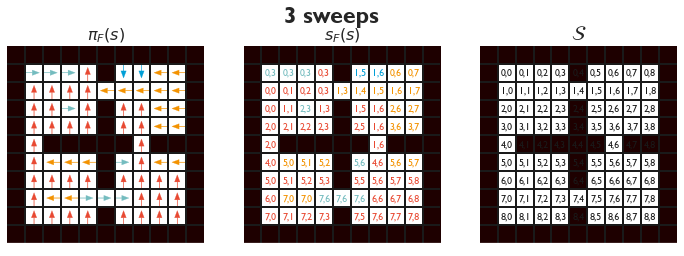

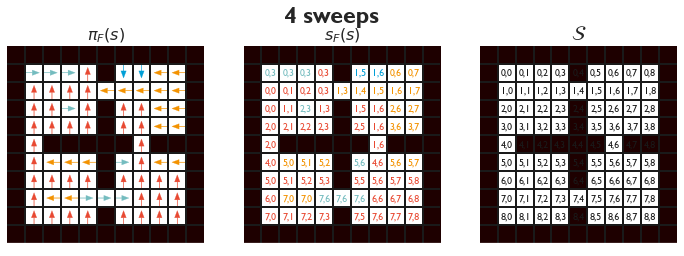

In [11]:
# let's visualize some plans
grid = FourRooms()
for i,pl in enumerate(pl_agents):
    cs = ['C5', 'C6', 'C0', 'C3']
    pi_F, s_F = pl.Policies, pl.Subgoals
    goal_state = 15
    grid.plot_planning_output(
        np.reshape(pi_F[goal_state], grid._layout.shape),
        np.reshape(s_F[goal_state], grid._layout.shape),
        colors=cs[:len(np.unique(pi_F[goal_state]))],
        show_states=True,
        suptitle=f"{i} sweeps" if i != 1 else "1 sweep",
        Pi=Pi
    )

    plt.show()

We then run each agent for 100 episodes and evaluate performance. 

In [12]:
planning_results = []
for i,pl in enumerate(pl_agents):
    grid = FourRooms(reset_goal=True)
    pl_results = run_experiment_episodic(
        grid, pl, 100, display_eps=1, respect_done=True, max_ep_len=75
    )
    planning_results.append(pl_results['return hist'])
    
planning_results = np.stack(planning_results)

ep 100/100: mean return = 92.67784929660145

as a lower bound, we can do GPI

In [14]:
# first need the state-action FRs
FRs_sa = []
# multiple start states 
grid = FourRooms()
start_states = grid._possible_reward_states 
for i, pi in enumerate(Pi): 
    print (f"\nlearning FR for policy {i+1}")
    fr_agent = FR(grid._layout.size, 4, grid.get_obs(),
              policy=greedy, q=pi.q,
              step_size=0.08, sa=True)
    for start in start_states:
        fr_agent._state = start
        grid = FourRooms(start_state=start, discount=0.95)
        _ = run_experiment_episodic(
            grid, fr_agent, 100, display_eps=50, respect_done=False, max_ep_len=10
        )
    
    FRs_sa.append(fr_agent.FR)


learning FR for policy 1
ep 100/100: mean return = -3.13049815447080042
learning FR for policy 2
ep 100/100: mean return = -7.62399815447079782
learning FR for policy 3
ep 100/100: mean return = -7.62399815447079759
learning FR for policy 4
ep 100/100: mean return = -2.63174815447089953

In [15]:
# now we can define and test a GPE + GPI agent over 100 episodes
grid = FourRooms()
gpi_agent = GPIAgent(
    grid._layout.size, 4, grid.get_obs(), grid.r, FRs_sa
)

grid = FourRooms(reset_goal=True)
gpi_results = run_experiment_episodic(
    grid, gpi_agent, 100, display_eps=2, respect_done=True, max_ep_len=75
)

mean_gpi, std_gpi = np.mean(gpi_results['return hist']), np.std(gpi_results['return hist'])

ep 100/100: mean return = 13.848269477577922

As an upperbound, we can run value iteration (VI)

In [16]:
grid = FourRooms()
vi_agent = VI(
    grid._layout.size, 4, grid.get_obs(), grid._P, grid.r, grid.discount
)

grid = FourRooms(reset_goal=True)
vi_results = run_experiment_episodic(
    grid, vi_agent, 100, display_eps=2, respect_done=True, max_ep_len=75
)
mean_vi, std_vi = np.mean(vi_results['return hist']), np.std(vi_results['return hist'])

ep 100/100: mean return = 96.07299200024826

In [17]:
# we can also run VI with limited iterations
vi_means, vi_stds = [], []
for N in range(5):

    grid = FourRooms(reset_goal=True)
    vi_agent = VI(
        grid._layout.size, 4, grid.get_obs(), grid._P, grid.r, grid.discount, max_iters=N
    )

    vi_results = run_experiment_episodic(
        grid, vi_agent, 100, display_eps=2, respect_done=True, max_ep_len=75
    )
    
    m, s = np.mean(vi_results['return hist']), np.std(vi_results['return hist'])
    vi_means.append(m)
    vi_stds.append(s)

ep 100/100: mean return = 5.2209937264719315125

Let's plot the results

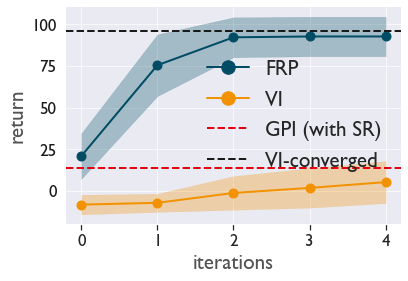

In [20]:
fig, ax = plt.subplots()
n = planning_results.shape[0]

m = np.mean(planning_results, axis=1)
s = np.std(planning_results, axis=1)
errorfill(
    np.arange(n), m, s / 2, color='C4', ax=ax, lw=2, marker='o', label="FRP"
)

vi_m, vi_s = np.array(vi_means), np.array(vi_stds)
errorfill(
    np.arange(n), vi_m, vi_s / 2, color='C3', ax=ax, lw=2, marker='o', label='VI'
)

ax.set_xticks(np.arange(n))
ax.tick_params(labelsize=17)
ax.set_ylabel("return", fontsize=21)
ax.set_xlabel("iterations", fontsize=21)

# gpi lower bound
ax.axhline(y=mean_gpi, c='C1', ls='--', lw=2, label='GPI (with SR)')

# VI upper bound
ax.axhline(y=mean_vi, c='k', ls='--', lw=2, label='VI-converged')

ax.legend(loc='center right', fontsize=21)
plt.show()

Now we can test the effect of noise in the transition dynamics

In [73]:
# learn the FRs for the base policies
Pi = [pi1, pi2, pi3, pi4]
noises = 0.1 * np.arange(11) 

frp_means = []
frp_stds = []

for eps in noises:
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print (f"training on eps = {eps}...")
    FRs = []
    # multiple start states 
    grid = FourRooms(noise=eps)
    start_states = grid._possible_reward_states 
    for i, pi in enumerate(Pi): 
        print (f"\nlearning FR for policy {i+1}")
        fr_agent = FR(grid._layout.size, 4, grid.get_obs(),
                  policy=greedy, q=pi.q,
                  step_size=0.08, sa=False)
        for start in start_states:
            fr_agent._state = start
            grid = FourRooms(start_state=start, discount=0.95)
            _ = run_experiment_episodic(
                grid, fr_agent, 150, display_eps=50, respect_done=True, max_ep_len=10
            )

        FRs.append(fr_agent.FR)
        
    # define frp agent
    frp_agent = FRPAgent(
        grid._layout.size, 4, grid.get_obs(),
        grid._possible_reward_states, Pi, FRs, max_sweeps=3
    )
    
    # run 
    print ("\ntesting:")
    grid = FourRooms(reset_goal=True, noise=eps)
    frp_results = run_experiment_episodic(
        grid, frp_agent, 100, display_eps=1, respect_done=True, max_ep_len=75
    )
    
    frp_means.append(np.mean(frp_results['return hist']))
    frp_stds.append(np.std(frp_results['return hist']))
    


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
training on eps = 0.0...

learning FR for policy 1
ep 150/150: mean return = -2.83758148780413282
learning FR for policy 2
ep 150/150: mean return = -7.62399815447079772
learning FR for policy 3
ep 150/150: mean return = -7.623998154470797512
learning FR for policy 4
ep 150/150: mean return = -2.75920648780413254
testing:
ep 100/100: mean return = 98.65151618946173
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
training on eps = 0.1...

learning FR for policy 1
ep 150/150: mean return = -2.83758148780413282
learning FR for policy 2
ep 150/150: mean return = -7.62399815447079772
learning FR for policy 3
ep 150/150: mean return = -7.623998154470797512
learning FR for policy 4
ep 150/150: mean return = -2.75920648780413254
testing:
ep 100/100: mean return = 85.0487568134095
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
training on eps = 0.2...

learning FR for policy 1
ep 150/150: mean return = -2.83758148780413282
learning FR for policy 2
ep 150/150: mean return = -7.6239981544707977

And now VI...

In [74]:
vi_means, vi_stds = [], []
for eps in noises:
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~")
    print (f"training with eps={eps}...")
    grid = FourRooms(noise=eps)
    vi_agent = VI(
        grid._layout.size, 4, grid.get_obs(), grid._P, grid.r, grid.discount
    )

    grid = FourRooms(reset_goal=True, noise=eps)
    vi_results = run_experiment_episodic(
        grid, vi_agent, 100, display_eps=2, respect_done=True, max_ep_len=75
    )
    
    vi_means.append(np.mean(vi_results['return hist']))
    vi_stds.append(np.std(vi_results['return hist']))


~~~~~~~~~~~~~~~~~~~~~~~~
training with eps=0.0...
ep 100/100: mean return = 93.48560962179533
~~~~~~~~~~~~~~~~~~~~~~~~
training with eps=0.1...
ep 100/100: mean return = 82.48727017050619
~~~~~~~~~~~~~~~~~~~~~~~~
training with eps=0.2...
ep 100/100: mean return = 71.90837845676339
~~~~~~~~~~~~~~~~~~~~~~~~
training with eps=0.30000000000000004...
ep 100/100: mean return = 64.34248724455014
~~~~~~~~~~~~~~~~~~~~~~~~
training with eps=0.4...
ep 100/100: mean return = 57.47716091455021
~~~~~~~~~~~~~~~~~~~~~~~~
training with eps=0.5...
ep 100/100: mean return = 41.49561385481544
~~~~~~~~~~~~~~~~~~~~~~~~
training with eps=0.6000000000000001...
ep 100/100: mean return = 34.41666272728971
~~~~~~~~~~~~~~~~~~~~~~~~
training with eps=0.7000000000000001...
ep 100/100: mean return = 18.232930180057284
~~~~~~~~~~~~~~~~~~~~~~~~
training with eps=0.8...
ep 100/100: mean return = 11.08285798713506
~~~~~~~~~~~~~~~~~~~~~~~~
training with eps=0.9...
ep 100/100: mean return = 5.515365811039818
~~~~~~~~~~~~

GPI with SRs

In [78]:
# learn the FRs for the base policies
Pi = [pi1, pi2, pi3, pi4]
noises = 0.1 * np.arange(11) 

gpi_means = []
gpi_stds = []

for eps in noises:
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print (f"training on eps = {eps}...")
    SRs_sa = []
    # multiple start states 
    grid = FourRooms(noise=eps)
    start_states = grid._possible_reward_states 
    for i, pi in enumerate(Pi): 
        print (f"\nlearning SR for policy {i+1}")
        sr_agent = SR(grid._layout.size, 4, grid.get_obs(),
                  policy=greedy, q=pi.q,
                  step_size=0.08, sa=True)
        for start in start_states:
            sr_agent._state = start
            grid = FourRooms(start_state=start, discount=0.95)
            _ = run_experiment_episodic(
                grid, sr_agent, 150, display_eps=50, respect_done=True, max_ep_len=10
            )

        SRs_sa.append(sr_agent.SR)
        
    # define gpi agent
    grid = FourRooms(reset_goal=True, noise=eps)
    gpi_agent = GPIAgent(
        grid._layout.size, 4, grid.get_obs(), grid.r, SRs_sa
    )

    # run 
    print ("\ntesting:")
    gpi_results = run_experiment_episodic(
        grid, gpi_agent, 100, display_eps=2, respect_done=True, max_ep_len=75
    )

    
    gpi_means.append(np.mean(gpi_results['return hist']))
    gpi_stds.append(np.std(gpi_results['return hist']))
    


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
training on eps = 0.0...

learning SR for policy 1
ep 150/150: mean return = -2.83758148780413282
learning SR for policy 2
ep 150/150: mean return = -7.62399815447079772
learning SR for policy 3
ep 150/150: mean return = -7.623998154470797512
learning SR for policy 4
ep 150/150: mean return = -2.75920648780413254
testing:
ep 100/100: mean return = 18.022940414936354
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
training on eps = 0.1...

learning SR for policy 1
ep 150/150: mean return = -2.83758148780413282
learning SR for policy 2
ep 150/150: mean return = -7.62399815447079772
learning SR for policy 3
ep 150/150: mean return = -7.623998154470797512
learning SR for policy 4
ep 150/150: mean return = -2.75920648780413254
testing:
ep 100/100: mean return = 14.84809585554898
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
training on eps = 0.2...

learning SR for policy 1
ep 150/150: mean return = -2.83758148780413282
learning SR for policy 2
ep 150/150: mean return = -7.62399815447079

And we can finally plot our results:

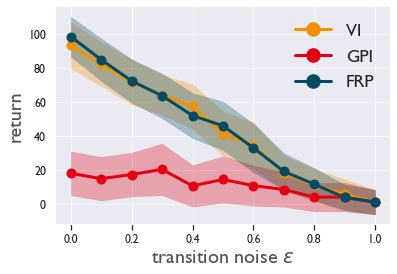

In [81]:
errorfill(
    noises, np.array(vi_means), np.array(vi_stds) / 2,
    label='VI', color='C3', lw=3, marker='o'
)
errorfill(
    noises, np.array(gpi_means), np.array(gpi_stds) / 2,
    label='GPI', color='C1', lw=3, marker='o'
)
errorfill(
    noises, np.array(frp_means), np.array(frp_stds) / 2,
    label='FRP', color='C4', lw=3, marker='o'
)
plt.xlabel(r"transition noise $\epsilon$", fontsize=20)
plt.ylabel(r"return", fontsize=20)
plt.legend(fontsize=18)

plt.show()